In [1]:
import os
import random
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

sys.path.append("../..")

from gemini.utils import *
from drift_detector.rolling_window import *
from baseline_models.temporal.pytorch.optimizer import Optimizer
from baseline_models.temporal.pytorch.utils import *

2022-08-25 09:13:29,650 INFO cyclops.orm     - Database setup, ready to run queries!


In [2]:
PATH = "/mnt/nfs/project/delirium/drift_exp/JULY-04-2022"
threshold=0.05
num_timesteps = 6
run=1
shift="covid"
hospital = ["SBK", "UHNTG", "THPC", "THPM", "UHNTW", "SMH","MSH","PMH"]
outcome="mortality"
aggregation_type="time"
scale=True

In [3]:
admin_data, x, y = get_gemini_data(PATH)

numerical_cols = get_numerical_cols(PATH)
for col in numerical_cols:
    scaler = StandardScaler().fit(x[col].values.reshape(-1, 1))
    x[col] = pd.Series(
        np.squeeze(scaler.transform(x[col].values.reshape(-1, 1))),
        index=x[col].index,
    )
X = reshape_inputs(x, num_timesteps)

2022-08-25 09:13:29,714 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggregated_events.parquet


Load data from aggregated events...


2022-08-25 09:13:31,344 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_start_ts.parquet
2022-08-25 09:13:31,761 INFO cyclops.feature_handler - Loading features from file...
2022-08-25 09:13:31,763 INFO cyclops.feature_handler - Found file to load for static features...
2022-08-25 09:13:31,766 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-08-25 09:13:31,862 INFO cyclops.feature_handler - Found file to load for temporal features...


Load data from feature handler...


2022-08-25 09:13:37,302 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


Load data from admin data...


2022-08-25 09:13:47,155 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_end_ts.parquet
2022-08-25 09:14:07,012 INFO cyclops.feature_handler - Loading features from file...
2022-08-25 09:14:07,014 INFO cyclops.feature_handler - Found file to load for static features...
2022-08-25 09:14:07,015 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-08-25 09:14:07,043 INFO cyclops.feature_handler - Found file to load for temporal features...
2022-08-25 09:14:11,802 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


In [4]:
(x_train, y_train), (x_val, y_val), (x_test, y_test), feats, admin_data = import_dataset_hospital(admin_data, x, y, shift, outcome, hospital, run, shuffle=True)

random.seed(1)

# Normalize data
(X_tr_normalized, y_tr),(X_val_normalized, y_val), (X_t_normalized, y_t) = normalize_data(aggregation_type, admin_data, num_timesteps, x_train, y_train, x_val, y_val, x_test, y_test)
# Scale data
if scale:
    X_tr_normalized, X_val_normalized, X_t_normalized = scale_data(numerical_cols, X_tr_normalized, X_val_normalized, X_t_normalized)
# Process data
X_tr_final, X_val_final, X_t_final = process_data(aggregation_type, num_timesteps, X_tr_normalized, X_val_normalized, X_t_normalized)

## Create Data Streams

In [5]:
start_date = date(2019, 1, 1)
end_date = date(2020, 8, 1)

val_ids=list(X_val_normalized.index.get_level_values(0).unique())

x_test_stream, y_test_stream, measure_dates_test = get_streams(x, y, admin_data, start_date, end_date, stride=1, window=1, ids_to_exclude=val_ids)

2019-01-01 - 2019-01-02
2020-01-01 - 2020-01-02


## Dynamic Rolling Window

In [6]:
random.seed(1)
# rolling window parameters
threshold = 0.05
num_timesteps = 6
stat_window=30
lookup_window=0
stride=1
# model parameters
output_dim = 1
batch_size = 64
input_dim = 108
timesteps = 6
hidden_dim = 64
layer_dim = 2
dropout = 0.2
n_epochs = 1
learning_rate = 2e-3
weight_decay = 1e-6
last_timestep_only = False
device = get_device()
model_params = {
    "device": device,
    "input_dim": input_dim,
    "hidden_dim": hidden_dim,
    "layer_dim": layer_dim,
    "output_dim": output_dim,
    "dropout_prob": dropout,
    "last_timestep_only": last_timestep_only,
}
#drift detector parameters
dr_technique="BBSDs_trained_LSTM"
model_path=os.path.join(os.getcwd(),"../../saved_models/"+shift+"_lstm.pt")
md_test="MMD"
sign_level=0.05
sample=1000
dataset="gemini"
context_type="rnn"
representation="rf"

#retrain parameters
model_name="rnn"
retrain=True

# Get shift reductor
shift_reductor = ShiftReductor(
    X_tr_final, y_tr, dr_technique, dataset, var_ret=0.8, model_path=model_path,
)
# Get shift detector
shift_detector = ShiftDetector(
    dr_technique, md_test, sign_level, shift_reductor, sample, dataset, feats, model_path, context_type, representation,
)

if model_name == "rnn":
    model = get_temporal_model("lstm", model_params).to(device)
    model_path = os.path.join(os.getcwd(),'../../saved_models/',shift+"_lstm.pt")
    model.load_state_dict(torch.load(model_path))
    
    loss_fn = nn.BCEWithLogitsLoss(reduction="none")
    optimizer = optim.Adagrad(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay
    )
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=128, gamma=0.5)
    activation = nn.Sigmoid()
    opt = Optimizer(
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        activation=activation,
        lr_scheduler=lr_scheduler,
    )
if model_name == "gbt":
    with open(model_path, 'rb') as f:
        model = pickle.load(f)    

#####################################################
## low confidence adjusting drift detector - if drift is significant, reference dataset is reset to current time 
#####################################################
def confidence_rolling_window(X_train, X_stream, y_stream, shift_detector, sample, stat_window, lookup_window, stride, num_timesteps, threshold, model_name, model, opt=None, X_ref=None, retrain=True):

    p_vals = np.asarray([])
    dist_vals = np.asarray([])
    rolling_metrics = []
    run_length = int(stat_window) 
    
    i = stat_window
    p_val=1
    total_alarms = 0 
    verbose=0
    
    if X_ref is not None:
        X_prev = X_ref
        # create val loader
        
    while i+stat_window+lookup_window <= len(X_stream):
        feat_index = 0
        
        if p_val < threshold:
            
            if retrain:
                
                ## Get data for updated fit 
                X_update = pd.concat(X_stream[max(int(i)-run_length,0):int(i)])
                X_update = X_update[~X_update.index.duplicated(keep='first')]
                ind = X_update.index.get_level_values(0).unique()
                X_update = reshape_inputs(X_update, num_timesteps)
                
                y_update = pd.concat(y_stream[max(int(i)-run_length,0):int(i)])
                y_update.index = ind
                y_update = y_update[~y_update.index.duplicated(keep='first')].to_numpy()

                ## Get updated source (validation) data for two-sample test (including data for retraining) 
                X_prev = np.concatenate((X_prev, X_update), axis=0)
                tups = [tuple(row) for row in X_prev]
                X_prev = np.unique(tups, axis=0)
                np.random.shuffle(X_prev)                 

                
                print("Retrain ",model_name," on: ",max(int(i)-run_length,0),"-",int(i))

                if model_name == "rnn":
                    ## create train loader 
                    update_dataset = get_data(X_update, y_update)
                    update_loader = torch.utils.data.DataLoader(update_dataset, batch_size=1, shuffle=False)

                    retrain_model_path='adaptive_window_retrain.model'

                    ## train 
                    opt.train(
                         update_loader,
                         update_loader,
                         batch_size=batch_size,
                         n_epochs=n_epochs,
                         n_features=input_dim,
                         timesteps=timesteps,
                         model_path=retrain_model_path,
                    )

                    model.load_state_dict(torch.load(retrain_model_path))
                    opt.model = model
                    shift_detector.model_path = retrain_model_path

                elif model_name == "gbt":
                    model = model.fit(X_retrain, y_retrain, xgb_model=model.get_booster())

                else:
                    print("Invalid Model Name")

            i += stride

        if X_ref is None:
            X_prev = pd.concat(X_stream[max(int(i)-run_length,0):int(i)+stat_window])
            X_prev = X_prev[~X_prev.index.duplicated(keep='first')]
            X_prev = reshape_inputs(X_prev, num_timesteps)
        
        ## Get next stream of test data
        X_next = pd.concat(X_stream[max(int(i)+lookup_window,0):int(i)+stat_window+lookup_window])
        X_next = X_next[~X_next.index.duplicated(keep='first')]
        next_ind = X_next.index.get_level_values(0).unique()
        X_next = reshape_inputs(X_next, num_timesteps)
        
        y_next = pd.concat(y_stream[max(int(i)+lookup_window,0):int(i)+stat_window+lookup_window])
        y_next.index = next_ind
        y_next = y_next[~y_next.index.duplicated(keep='first')].to_numpy()
        
        ## Ensure next stream of test data is not empty
        if X_next.shape[0]<=2 or X_prev.shape[0]<=2:
            break
        
        ## Check Performance 
        test_dataset = get_data(X_next, y_next)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
        y_test_labels, y_pred_values, y_pred_labels = opt.evaluate(
            test_loader, batch_size=1, n_features=input_dim, timesteps=num_timesteps
        )

        y_pred_values = y_pred_values[y_test_labels != -1]
        y_pred_labels = y_pred_labels[y_test_labels != -1]
        y_test_labels = y_test_labels[y_test_labels != -1]
        
       # print(y_pred_values)
            
        pred_metrics = print_metrics_binary(y_test_labels, y_pred_values, y_pred_labels, verbose=verbose)
        rolling_metrics.append(pd.DataFrame(pred_metrics.values(),index=pred_metrics.keys()).T)
        
            
        ## Run distribution shift check here
        (p_val, dist, val_acc, te_acc) = shift_detector.detect_data_shift(X_train, 
                                                                          X_prev[:1000,:], 
                                                                          X_next[:sample,:]
        )

    #    print(max(int(i)-run_length,0),"-", int(i),"-->",max(int(i)+lookup_window,0),"-",int(i)+stat_window+lookup_window,"\tP-Value: ",p_val)
        
        dist_vals = np.concatenate((dist_vals, np.repeat(dist, 1)))
        p_vals = np.concatenate((p_vals, np.repeat(p_val, 1)))

        if p_val >= threshold:
            run_length += stride
            i += stride
        else:
            run_length= stat_window
            total_alarms += 1
    
    rolling_metrics = pd.concat(rolling_metrics).reset_index(drop=True)
    
    return dist_vals, p_vals, rolling_metrics, total_alarms

dist_test, pvals_test, performance_metrics, total_alarms = confidence_rolling_window(X_tr_final, x_test_stream, y_test_stream, shift_detector, sample, stat_window, lookup_window, stride, num_timesteps, threshold, model_name=model_name, model=model,opt=opt, X_ref=X_val_final, retrain=retrain)

Retrain  rnn  on:  22 - 52
[1/1] Training loss: 0.8197	 Validation loss: 0.6345
Retrain  rnn  on:  23 - 53
[1/1] Training loss: 0.6909	 Validation loss: 0.6509
Retrain  rnn  on:  24 - 54
[1/1] Training loss: 0.6607	 Validation loss: 0.6380
Retrain  rnn  on:  25 - 55
[1/1] Training loss: 0.6609	 Validation loss: 0.6431
Retrain  rnn  on:  27 - 57
[1/1] Training loss: 0.6475	 Validation loss: 0.6338
Retrain  rnn  on:  28 - 58
[1/1] Training loss: 0.6496	 Validation loss: 0.6322
Retrain  rnn  on:  55 - 85
[1/1] Training loss: 0.6865	 Validation loss: 0.6681
Retrain  rnn  on:  56 - 86


KeyboardInterrupt: 

In [8]:
total_alarms

68

In [18]:
import numpy as np, scipy.stats as st
mean = np.mean(pvals_test[pvals_test<0.05])
ci = st.t.interval(0.95, len(pvals_test[pvals_test<0.05])-1, loc=np.mean(pvals_test[pvals_test<0.05]), scale=st.sem(pvals_test[pvals_test<0.05]))
print(mean, ci)

0.010317460086847108 (0.006963858661874427, 0.01367106151181979)


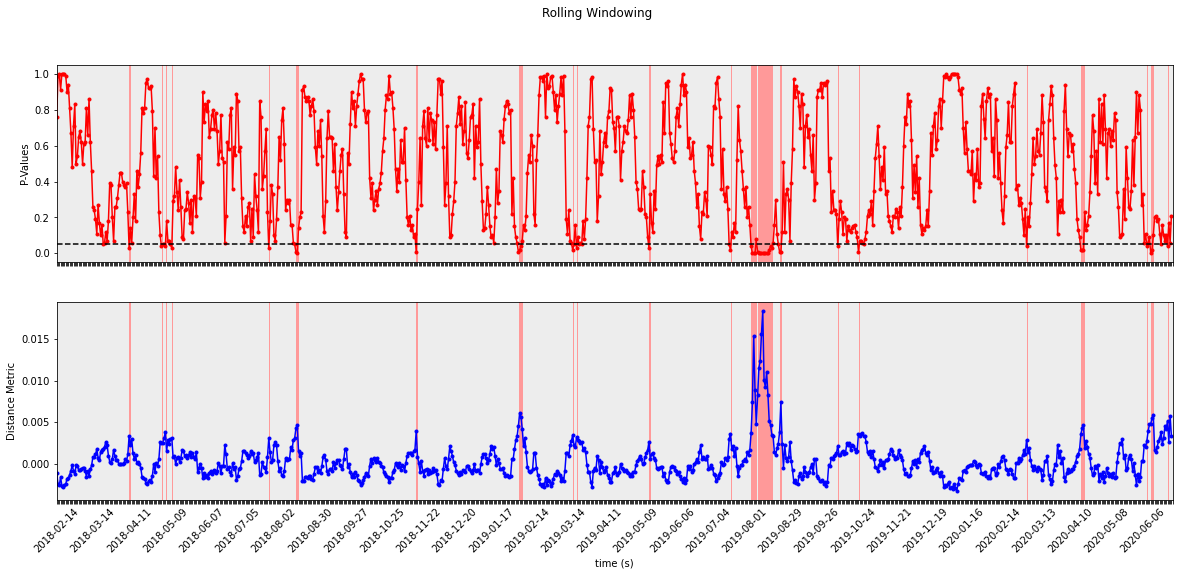

In [55]:
end = performance_metrics.shape[0]
threshold=0.05
measure_dates_test_adjust = [(datetime.datetime.strptime(date,"%Y-%m-%d")+datetime.timedelta(days=lookup_window+stat_window)).strftime("%Y-%m-%d") for date in measure_dates_test]
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(22,12))
results = pd.DataFrame(
    {'dates': measure_dates_test_adjust[0:end],
     'pval': pvals_test[0:end],
     'dist': dist_test[0:end],
     'detection': np.where(pvals_test[0:end]<threshold,1,0)
    })
results = pd.concat([results,performance_metrics],axis=1)
results.to_pickle(os.path.join(PATH,shift,shift+"_"+dr_technique+"_"+md_test+"_results.pkl")) 
start = 0 
end = performance_metrics.shape[0]-1
cmap = ListedColormap(['lightgrey','red'])
ax1.plot(results['dates'], results['pval'], '.-', color="red", linewidth=0.5, markersize=2)
ax1.set_xlim(results['dates'][start], results['dates'][end])
ax1.axhline(y=threshold, color='dimgrey', linestyle='--')
ax1.set_ylabel('P-Values',fontsize=16)
ax1.set_xticklabels([])
ax1.pcolorfast(ax1.get_xlim(), ax1.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)
  
ax2.plot(results['dates'], results['dist'], '.-',color="red", linewidth=0.5, markersize=2)
ax2.set_xlim(results['dates'][start], results['dates'][end])
ax2.set_ylabel('Distance',fontsize=16)
ax2.axhline(y=np.mean(results['dist']), color='dimgrey', linestyle='--')
ax2.set_xticklabels([])
ax2.pcolorfast(ax2.get_xlim(), ax2.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)

ax3.plot(results['dates'], results['auroc'], '.-',color="blue", linewidth=0.5, markersize=2)
ax3.set_xlim(results['dates'][start], results['dates'][end])
ax3.set_ylabel('AUROC', fontsize=16)
ax3.axhline(y=np.mean(results['auroc']), color='dimgrey', linestyle='--')
ax3.set_xticklabels([])
ax3.pcolorfast(ax3.get_xlim(), ax3.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)

ax4.plot(results['dates'], results['auprc'], '.-',color="blue", linewidth=0.5, markersize=2)
ax4.set_xlim(results['dates'][start], results['dates'][end])
ax4.set_ylabel('AUPRC',fontsize=16)
ax4.axhline(y=np.mean(results['auprc']), color='dimgrey', linestyle='--')
ax4.set_xticklabels([])
ax4.pcolorfast(ax4.get_xlim(), ax4.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)

ax5.plot(results['dates'], results['prec1'], '.-',color="blue", linewidth=0.5, markersize=2)
ax5.set_xlim(results['dates'][start], results['dates'][end])
ax5.set_ylabel('PPV', fontsize=16)
ax5.axhline(y=np.mean(results['prec1']), color='dimgrey', linestyle='--')
ax5.set_xticklabels([])
ax5.pcolorfast(ax5.get_xlim(), ax5.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)

ax6.plot(results['dates'], results['rec1'], '.-',color="blue", linewidth=0.5, markersize=2)
ax6.set_xlim(results['dates'][start], results['dates'][end])
ax6.set_ylabel('Sensitivity',fontsize=16)
ax6.set_xlabel('time (s)', fontsize=16)
ax6.axhline(y=np.mean(results['rec1']), color='dimgrey', linestyle='--')
ax6.tick_params(axis='x', labelrotation=45)
ax6.pcolorfast(ax6.get_xlim(), ax6.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)

for index, label in enumerate(ax6.xaxis.get_ticklabels()):
    if index % 28 != 0:
        label.set_visible(False)

plt.show()